<a id="table_of_contents"></a>
## Table of Contents

1. [Introduction](#intro)
    * 1.1 [Problem Statement](#problem_statement)
    * 1.2 [Data Gathering](#data_gathering)
2. [Setup](#setup)
    * 2.1 [Importing the Data](#import)
3. [General](#general)
    * 3.1 [Shape](#shape)
    * 3.2 [Statistics](#stats)
    * 3.3 [Hygiene](#hygiene)
4. [Cohort Analysis](#cohort)
    * 4.1 [Data Cleaning](#data_cleaning)
    * 4.2 [Invoiceno Test](#invoiceno)
    * 4.3 [Quantity/Price Test](#quantityprice)
    * 4.4 [Completing Variables](#iddesc)
    * 4.5 [Creating New Variables](#creating)
    * 4.6 [Calculate Absolute Cohorts and Retention](#retention)
    * 4.7 [Calculate Average Price](#price)
    * 4.8 [Calculate Average Quantity](#quantity)
5. [Cohort Analysis Visualization](#eda)
6. [RFM Analysis](#rfm)
    * 6.1 [RFM Scoring](#rfm_scoring)
    * 6.2 [RFM Profiling](#rfm_profiling)
7. [Segmentation](#segmentation)
    * 7.1 [K-Means](#kmeans)
    * 7.2 [Choosing K](#choosing_k)
    * 7.3 [Scree Plot](#screeplot)
    * 7.4 [K Clusters](#k_clusters)
    * 7.5 [Snake Plots](#snake_plots)
    * 7.6 [Importance Scores](#importance)

<a id="intro"></a>

## 1. Introduction

[back to top](#table_of_contents)

<a id="problem_statement"></a>

## 1.1 Problem Statement

**Describe the dataset?**


[back to top](#table_of_contents)

<a id="data_gathering"></a>

## 1.2 Data Gathering

The dataset from ?? dataset 

[back to top](#table_of_contents)

<a id="setup"></a>

## 2. Setup

**Packages required** 
* Data manipulation 
* Visualization 
* Modelling 
* Validation 

[back to top](#table_of_contents)

In [4]:
# Manipulation  
import numpy as np 
import pandas as pd
import re
import datetime as dt

# Visualization 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# ignore warnings 
# import warnings 
# warnings.filterwarnings('ignore')

# Modelling 
from sklearn.cluster import KMeans

# Preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
# For feature select
from sklearn.feature_selection import SelectFromModel, RFECV

# Validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, ShuffleSplit, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix

import os



['#4878d0', '#ee854a', '#6acc64', '#d65f5f', '#956cb4', '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']


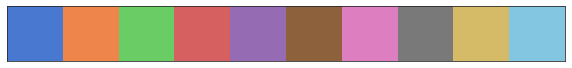

In [5]:
# Set styles 
%matplotlib inline

# mpl.style.use('ggplot')
pd.set_option('display.max_rows', 1000)
sns.set_style('white')
sns.set_palette('muted')
pylab.rcParams['figure.figsize'] = 16, 10
background_color = '#f6f5f5'
col_blue = '#4878d0'
col_orange = '#ee854a'

# Colour palette hex references 
pal = sns.color_palette('muted')
sns.palplot(pal)
print(pal.as_hex())

<a id = 'import'></a>
## 2.1 Importing the Data

#### Varia

* Invoice No:
* Stock Code:
* Description: 
* Quantity:
* Invoice Date:
* Unit Price:
* Customer ID: 
* Country:

[back to top](#table_of_contents)

In [ ]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv')

<a id="general"></a>

## 3. General 

**Notes from the initial familiarization of the dataset here**

* Dataset has X categorical variables: country
* Dataset has X continuous variables: quantity, invoicedate, unitprice
* Dataset: invoiceno -> unique, stockcode, description, customerid
* Dataset has 541,909 rows

[back to top](#table_of_contents)

<a id="shape"></a>
## 3.1 Shape

[back to top](#table_of_contents)

In [ ]:
print(f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns')

<a id='stats'></a>

## 3.2 Statistics 

[back to top](#table_of_contents)

In [ ]:
# Familiarization 

print(df.info())

# note that minimum values of price and quantity are negative 
df.describe().T

<a id = 'hygiene'></a>

## 3.3 Hygiene 

* Convert column names to lowercase
* Convert date to datetime format

[back to top](#table_of_contents)

In [ ]:
# Convert columns names to lowercase
df.columns = [c.lower() for c in df.columns]    
df.columns

In [ ]:
display(df['invoicedate'].values)

In [ ]:
## Convert invoicedate to datetime 

df['invoicedate'] = pd.to_datetime(df['invoicedate'],
                                   errors = 'raise',
                                   format = '%m/%d/%Y %H:%M')

# check 
df.info()

In [ ]:
# sort transactions by time 
df = df.sort_values(by = 'invoicedate', axis = 0, ascending = True)

In [ ]:
# print first 5 rows
df.head()

<a id = 'cohort'></a>
## 4. Cohort Analysis 

A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts. Cohorts are used in medicine, psychology, econometrics, ecology and many other areas to perform a cross-section (compare difference across subjects) at intervals through time.

**Types of cohorts:**

* Time Cohorts are customers who signed up for a product or service during a particular time frame. Analyzing these cohorts shows the customers’ behavior depending on the time they started using the company’s products or services. The time may be monthly or quarterly even daily.
* Behavior cohorts are customers who purchased a product or subscribed to a service in the past. It groups customers by the type of product or service they signed up. Customers who signed up for basic level services might have different needs than those who signed up for advanced services. Understaning the needs of the various cohorts can help a company design custom-made services or products for particular segments.
* Size cohorts refer to the various sizes of customers who purchase company’s products or services. This categorization can be based on the amount of spending in some periodic time after acquisition or the product type that the customer spent most of their order amount in some period of time.


**Approach** 
* Creating a deep copy for cohort analysis

[back to top](#table_of_contents)


In [ ]:
dfc = df.copy(deep = True)

<a id='data_cleaning'></a>
## 4.1 Data Cleaning

**The data cleaning process involves going through and applying the 4Cs to the data**
1. Completing - are there any **missing values**? 
 * ~customerid: lots of missing customer ids~ Transactions dropped (cancelled)
 * ~description: missing description~ Transactions dropped<br></br>
 
2. Correcting - are there any values that **look weird**?  
 * ~unitprice: There are negative values~ Transactions dropped (likely free gifts)
 * ~invoiceno: There are values that start with C~ Cancelled values to drop
 * ~quantity: There are negative values~ Transactions dropped (likely refunded)<br></br>

3. Creating - are there any features that we can **engineer** to help solve our problem? 
 * ~invoicedate: Creating month, year, day~
 * ~totalvalue: quantity x price~<br></br>
 
4. Converting - are all features in the **right dtypes?** 
 * ~Converting invoicedate to datetime~ converted 

[back to top](#table_of_contents)

<a id = 'invoiceno'></a>

## 4.2 Invoiceno test

**Notes**
* Test if all of invoiceno are numeric values: no 
* Check unique values that start with an alphabet: all start with C
* Hypothesis: C represents cancelled orders 

[back to top](#table_of_contents)

In [ ]:
# pd.to_numeric(dfc['invoiceno'], errors = 'raise')

# error generated: Unable to parse string "C536379" at position 119

In [ ]:
# 9291 values 
odd_invoicenos = [i for i in dfc['invoiceno'] if i[0].isalpha()]
print(f'These {len(odd_invoicenos)} invoices are odd')

In [ ]:
odd_invoicenos[:20]

# seem to be all Cs

#### Hypothesis: These represent cancelled orders

#### Strategy: extract out the C-invoices and check 

In [ ]:
dfc['cancelled'] = dfc['invoiceno'].apply(lambda x: 1 if x[0] == 'C' else 0)

#### All of the cancelled items seem to have negative quantities

In [ ]:
dfc.loc[dfc['cancelled'] == 1].head(10)

In [ ]:
# Check whether there's any non negative
len(dfc.loc[(dfc['cancelled'] == 1) & (dfc['quantity'] >= 0)])

<a id = 'quantityprice'></a>

## 4.3 Quantity / Price Test

**Notes**
* Test if quantities and price are all above 0
* Check for non-cancelled orders that have quantities / price < 0
* Hypothesis: these are orders that have gone missing / broken somehow, therefore, their cost has been refunded

[back to top](#table_of_contents)

In [ ]:
neg_quantities = dfc.loc[(dfc['quantity'] < 0) & (dfc['cancelled'] == 0)]
neg_quantities.head(15)

#### Descriptions have NaN values 

In [ ]:
print(f"There are {neg_quantities['description'].isna().sum()} NA values for description")

In [ ]:
# negative quantities have various refund reasons 
neg_quantities['description'].value_counts().head(10)

#### Check for unitprice equals 0: these are most likely free items as part of a promotional offer / giveaway

In [ ]:
dfc.loc[dfc['unitprice'] == 0]

In [ ]:
# refund as an adjustment to bad debt 
dfc.loc[dfc['unitprice'] < 0]

<a id = 'iddesc'></a>
## 4.4 Completing Variables

**Managing missing customerids and description** 

[back to top](#table_of_contents)

In [ ]:
msno.matrix(dfc)
plt.show()

In [ ]:
# total missing values 
print(f'There are {dfc.isna().sum().sum()} missing values')

# missing values by column 
dfc.isna().sum()

In [ ]:
dfc.dropna(subset = ['description', 'customerid'], axis = 0, inplace = True)

In [ ]:
dfc.isna().sum()

#### Drop cancelled transactions, transactions where the unitprice is <= 0, transactions where quantity <= 0  

In [ ]:
dfc = dfc[(dfc['cancelled'] == 0) & (dfc['unitprice'] > 0) & (dfc['quantity'] > 0)]

#### Check for duplicated values and drop

In [ ]:
# check for customerid duplicates and transaction duplicates
print(f"There are {dfc['customerid'].duplicated().sum()} repeat orders")
print(f'There are {dfc.duplicated().sum()} duplicates')

In [ ]:
dfc.drop_duplicates(inplace = True)

In [ ]:
print(f'There are {dfc.duplicated().sum()} duplicates')
print(f'Dataset has {dfc.shape[0]} rows and {dfc.shape[1]} columns')

In [ ]:
# Check stats for dfc

print(dfc.info())
dfc.describe().T

<a id = 'creating'></a>
## 4.5 Creating new variables  
 
* get invoicedates grouped by customers
* extract first transaction period
* calculate time offset in days
* calculate total value
* make cohort tables: retention, price, quantity  

[back to top](#table_of_contents)

#### Create a invoicedatetime column

In [ ]:
dfc['invoicedatetime'] = dfc['invoicedate']

#### Create a totalvalue column

In [ ]:
dfc['totalvalue'] = dfc['unitprice'] * dfc['quantity']

In [ ]:
# Define a function that will parse the dates 
def get_date(x): return dt.datetime(x.year, x.month, x.day)

# Define a function to extract the time from the datetime value
def get_time(x): return dt.time(x.hour, x.minute)

In [ ]:
dfc['invoicedate'] = dfc['invoicedatetime'].apply(get_date)
dfc['invoicetime'] = dfc['invoicedatetime'].apply(get_time)

In [ ]:
# time difference of about a year, which is compatible for a monthly cohort analysis > ~12 cohorts
print(f'Earliest date: {dfc["invoicedate"].dt.date.min()}')
print(f'Latest date: {dfc["invoicedate"].dt.date.max()}')
dfc['invoicedate'].value_counts().sort_index().head(10)

In [ ]:
def get_month(x): return dt.datetime(x.year, x.month, 1)

dfc['invoicemonth'] = dfc['invoicedate'].apply(get_month)

In [ ]:
# extract first transaction period: cohort join date
groupings = dfc.groupby('customerid')['invoicemonth']
dfc['cohortdate'] = groupings.transform('min')
dfc.head(10)

In [ ]:
# define a function to return the date components as integers
def get_date_int(df, col): 
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [ ]:
inv_year, inv_month, _ = get_date_int(dfc, 'invoicemonth')
coh_year, coh_month, _ = get_date_int(dfc, 'cohortdate')

#### We can calculate the months offset since the first transaction of each customer to arrive at the cohort 

In [ ]:
# Calculate year difference
year_diff = inv_year - coh_year

# Calculate month difference
month_diff = inv_month - coh_month

# Calculate the total time difference in days 
dfc['cohortindex'] = year_diff * 12 + month_diff + 1

dfc.head()

<a id = 'retention'></a>
## 4.6 Calculate Absolute Cohorts and Retention 

[back to top](#table_of_contents)

In [ ]:
# Count monthly active customers from each cohort 

grouping = dfc.groupby(['cohortdate', 'cohortindex'])
cohort_data = grouping['customerid'].apply(pd.Series.nunique)

display(cohort_data.head())

# Pivot by cohortdate and cohortindex to get the number of unique customers that made a purchase by cohort
cohort_data = cohort_data.reset_index()
absolutes = cohort_data.pivot(index = 'cohortdate', columns = 'cohortindex', values = 'customerid')

# Absolute unique customers 
absolutes

In [ ]:
# Extract the values from the first column 
cohort_sizes = absolutes.iloc[:, 0]
retention = absolutes.divide(cohort_sizes, axis = 0).round(3)*100

retention = retention.round(1)
retention.index = retention.index.date

retention

<a id = 'price'></a>
## 4.7 Calculating Average Price

[back to top](#table_of_contents)

In [ ]:
# Groupby cohortdate and cohortindex
grouping = dfc.groupby(['cohortdate', 'cohortindex']) 

# Calculate the unitprice average and reset index
cohort_data = grouping['unitprice'].mean()
cohort_data = cohort_data.reset_index()

# Create a price pivot 
price = cohort_data.pivot(index = 'cohortdate', columns = 'cohortindex', values = 'unitprice')
price = price.round(1)
price.index = price.index.date

price

<a id = 'quantity'></a>
## 4.8 Calculating Average Quantity

[back to top](#table_of_contents)

In [ ]:
grouping = dfc.groupby(['cohortdate', 'cohortindex'])
cohort_data = grouping['quantity'].mean()
cohort_data = cohort_data.reset_index()

# Create the quantity pivot table 
quantity = cohort_data.pivot(index = 'cohortdate', columns = 'cohortindex', values = 'quantity')
quantity = quantity.round()
quantity.index = quantity.index.date


quantity

<a id = 'eda'></a>
## 5. Cohort Analysis Visualization  

* Price 
* Quantity 
* Retention

[back to top](#table_of_contents)

In [ ]:
# define a plotting function 

def plot_table(df, vmin = 0, vmax = 10, cmap = 'Blues', title = ''):

    fig = plt.figure()
    gs = fig.add_gridspec(1, 1)
    ax0 = fig.add_subplot(gs[0, 0])

    sns.heatmap(df, ax = ax0, 
                annot = True, annot_kws = {'fontsize': 11},
                square = False, cbar = True, 
                vmin = vmin, vmax = vmax, 
                cmap = cmap, fmt = 'g')

    locals()['ax0'].set_title(f'{title}\n', fontsize = 15, fontweight = 'bold')
    locals()['ax0'].set_xlabel('')
    locals()['ax0'].set_ylabel('')
    locals()['ax0'].set_xticklabels(labels = df.columns, fontsize = 11)
    locals()['ax0'].set_yticklabels(labels = df.index, fontsize = 11)

    plt.show()

# define unique palettes for each 
cmap_r = sns.diverging_palette(22, 80, s = 70, l = 70, as_cmap = True)
cmap_p = sns.diverging_palette(22, 150, s = 80, l = 55, as_cmap = True)
cmap_q = sns.diverging_palette(22, 219, s = 80, l = 55, as_cmap = True)

In [ ]:
# Retention 
plot_table(retention, vmin = 20, vmax = 40, cmap = cmap_r, title = '% Retention Rate by Cohort')

In [ ]:
# Price 
plot_table(price, vmin = 1.5, vmax = 5, cmap = cmap_p, title = 'Average Price by Cohort')

In [ ]:
# Quantity 
plot_table(quantity, vmin = 5, vmax = 15, cmap = cmap_q, title = 'Average Quantity by Cohort')

<a id = 'rfm'></a>
## 6. RFM Analysis 

* RFM is an acronym of recency, frequency and monetary. Recency is about when was the last order of a customer. It means the number of days since a customer made the last purchase. If it’s a case for a website or an app, this could be interpreted as the last visit day or the last login time.

* Frequency is about the number of purchase in a given period. It could be 3 months, 6 months or 1 year. So we can understand this value as for how often or how many a customer used the product of a company. The bigger the value is, the more engaged the customers are. Could we say them as our VIP? Not necessary. Cause we also have to think about how much they actually paid for each purchase, which means monetary value.

* Monetary is the total amount of money a customer spent in that given period. Therefore big spenders will be differentiated with other customers such as MVP or VIP

[back to top](#table_of_contents)

To build the input features, we will start with RFM features – recency, frequency, monetary
* Recency – time since the last customer transaction
* Frequency – number of purchases in the observed period
* Monetary value – total amount spent in the observed period


Process of calculating percentiles:

* Sort customers based on that metric
* Break customers into a pre-defined number of groups of equal size
* Assign a label to each group

In [ ]:
dfc.head()

In [ ]:
print(f'Earliest invoice date: {dfc["invoicedatetime"].dt.date.min()}')
print(f'Most recent invoice date: {dfc["invoicedatetime"].dt.date.max()}')

dfc.head()

#### The last day of purchase is 9 Dec 2011; we can set the snapshot date as one day after the last to calculate the no. of days since last transaction

In [ ]:
# Creating the snapshotdate
snapshotdate = df['invoicedate'].max() + dt.timedelta(days = 1)

snapshotdate

In [ ]:
# Calculate RFM metrics
rfm = dfc.groupby(['customerid']).agg({'invoicedate': lambda x: (snapshotdate - x.max()).days,
                                       'invoiceno': 'count',
                                       'totalvalue': 'sum'})

rfm.rename(columns = {'invoicedate': 'recency', 
                      'invoiceno': 'frequency', 
                      'totalvalue': 'monetaryvalue'}, inplace = True)

# Resulting table is conducive for scoring and clustering 
rfm.head()

<a id = 'rfm_scoring'></a>

## 6.1 RFM Scoring 
Note That :

* We will rate "Recency" customer who have been active more recently better than the less recent customer,because each company wants its customers to be recent
* We will rate "Frequency" and "Monetary Value" higher label because we want Customer to spend more money and visit more often(that is different order than recency)

[back to top](#table_of_contents)

In [ ]:
# Creating labels for RFM segments 
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

# Assign labels to percentile gropus 
r_groups = pd.qcut(rfm['recency'], q = 4, labels = r_labels)
f_groups = pd.qcut(rfm['frequency'], q = 4, labels = f_labels)
m_groups = pd.qcut(rfm['monetaryvalue'], q = 4, labels = m_labels)

# Create new columns in the rfm df
rfm = rfm.assign(r_group = r_groups.values, f_group = f_groups.values, m_group = m_groups.values)

# Calculate RFM score and profile 

def add_rfm(x): return str(int(x['r_group'])) + str(int(x['f_group'])) + str(int(x['m_group']))
rfm['rfm_profile'] = rfm.apply(add_rfm, axis = 1)
rfm['rfm_score'] = rfm[['r_group', 'f_group', 'm_group']].sum(axis = 1)

rfm.head()

In [ ]:
# Random checks to make sure that the groups are making sense 
print(rfm.loc[rfm['r_group'] == 1, 'recency'].mean())
print(rfm.loc[rfm['r_group'] == 4, 'recency'].mean())

print(rfm.loc[rfm['f_group'] == 1, 'frequency'].mean())
print(rfm.loc[rfm['f_group'] == 4, 'frequency'].mean())

print(rfm.loc[rfm['m_group'] == 1, 'monetaryvalue'].mean())
print(rfm.loc[rfm['m_group'] == 4, 'monetaryvalue'].mean())

<a id = 'rfm_profiling'></a>

## 6.2 RFM Profiling

#### Largest RFM segments It is always the best practice to investigate the size of the segments before you use them for targeting or other business Application

[back to top](#table_of_contents)

In [ ]:
rfm.groupby(['rfm_profile']).size().sort_values(ascending = True).head()

#### Filtering by rfm profiles 

In [ ]:
#Select bottom RFM segment "111" and view top 5 rows
rfm[rfm['rfm_profile'] == '111'].head()

<a id = 'rfm_level'></a>

## 6.3 RFM Levels 

**Creating custom segments using the RFM score as a benchmark**

[back to top](#table_of_contents)

In [ ]:
rfm['rfm_level'] = pd.qcut(rfm['rfm_score'], q = 3, labels = ['low', 'middle', 'high'])

rfm.head()

In [ ]:
rfm.groupby('rfm_level').agg({'recency': 'mean',
                              'frequency': 'mean',
                              'monetaryvalue': ['mean', 'count']}).round(1)

<a id = 'segmentation'></a>

## 7. Segmentation

**We must check these key assumptions before we implement our K-Means algorithm**

* Symmetric distribution of variables (not skewed) - solution is to log-transform the variables  
* Variables with same average values and variance - solution is to standardize the variables 
* These assumptions can be check through the distplot / kdeplot 
* In the case of the ecommerce data, which is both skewed and of different scales, log-transformation must be done before scaling 
* The reason for this is that log-transformations only work with positive values

[back to top](#table_of_contents)

In [ ]:
rfm_raw = rfm[['recency','frequency','monetaryvalue']]
rfm_raw.describe().T

In [ ]:
def rfm_kde(df): 
    fig = plt.figure(figsize = (16, 25))
    gs = fig.add_gridspec(len(df.columns), 1)
    gs.update(wspace = 0.2, hspace = 0.2)

    run = 0 

    for row in range(len(df.columns)):
        for col in range(1):
            locals()[f'ax{run}'] = fig.add_subplot(gs[row, col])
            locals()[f'ax{run}'].set_yticklabels([])
            locals()[f'ax{run}'].tick_params(axis = 'y', which = 'both', length = 0)
            for s in ['top', 'right', 'left']:
                locals()[f'ax{run}'].spines[s].set_visible(False)
            run += 1

    run = 0

    for col in df:
        sns.kdeplot(df[col], ax = locals()[f'ax{run}'], shade = True, linewidth = 0.5)
        locals()[f'ax{run}'].grid(which = 'major', axis = 'x', zorder = 0, color = 'black', linestyle = ':', dashes = (1,5))
        locals()[f'ax{run}'].set_title(col, fontsize = 15, fontweight = 'bold')
        locals()[f'ax{run}'].set_xlim(df[col].min() - 2, df[col].max() + 2)
        locals()[f'ax{run}'].set_xlabel('')
        locals()[f'ax{run}'].set_ylabel('')
        run += 1

    plt.show()

In [ ]:
rfm_kde(rfm_raw)

In [ ]:
# Unskew the data with np.log
rfm_log = np.log(rfm_raw)

rfm_log

In [ ]:
# Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

rfm_log_norm = scaler.fit_transform(rfm_log)

In [ ]:
rfm_log_norm = pd.DataFrame(rfm_log_norm, columns = rfm_raw.columns, index = rfm_raw.index)

rfm_log_norm

In [ ]:
# Check the distributions of the rfm variables 
rfm_kde(rfm_log_norm)

<a id = 'kmeans'></a>

## 7.1 K-Means Clustering and Visualization¶

**Key steps**

* Data pre-processing
* Choosing a number of clusters
* Running k-means clustering on pre-processed data
* Analyzing average RFM values of each cluster

[back to top](#table_of_contents)

<a id = 'choosing_k'></a>

## 7.2 Choosing K

**Methods to define the number of clusters**

* Visual confirmation using the scree plot - identify elbow 
* Mathematically using the silhouette coefficient
* Plot the number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center
* Identify an "elbow" in the plot
* Elbow - a point representing an "optimal" number of clusters

[back to top](#table_of_contents)

In [ ]:


# Instantiate multiple values of K and record their within-cluster SSEs 

K = list(range(1, 10))
sse = {}

for k in K:
    # Create a KMeans trainer
    kmeans = KMeans(n_clusters = k, random_state = 123)
    kmeans.fit(rfm_log_norm)
    sse[k] = kmeans.inertia_

<a id = 'screeplot'></a>

## 7.3 Scree Plot

**Methods to define the number of clusters**

* Visual confirmation using the scree plot - identify elbow 
* Mathematically using the silhouette coefficient

[back to top](#table_of_contents)

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

for s in ['top', 'right', 'left', 'bottom']: 
    ax0.spines[s].set_visible(False)

sns.pointplot(x = list(sse.keys()), y = list(sse.values()), ax = ax0, color = col_blue)

ax0.set_title('Scree Plot (KMeans)\n', fontsize = 15, fontweight = 'bold')

ax0.set_xlabel('K', fontsize = 15)
ax0.set_ylabel('SSE', fontsize = 15)
ax0.set_xticklabels(K, fontsize = 15)
ax0.set_yticklabels('')

ax0.grid(which = 'major', axis = 'y', zorder = 0, color = 'black', linestyle = ':', dashes = (1,5))

plt.show()

<a id = 'k_clusters'></a>

## 7.4 K-Means Clusters

**Methods to define the number of clusters**

* Visual confirmation using the scree plot - identify elbow 
* Mathematically using the silhouette coefficient

[back to top](#table_of_contents)

In [ ]:
# Selection of k for clustering: 3

kmeans3 = KMeans(n_clusters = 3, random_state = 1)
kmeans3.fit(rfm_log_norm)

cluster_labels = kmeans3.labels_

rfm_k3 = rfm.assign(k_cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_k3.groupby('k_cluster').agg({'recency': 'mean',
                                 'frequency': 'mean',
                                 'monetaryvalue': ['mean', 'count']}).round(0)

<a id = 'snake_plots'></a>

## 7.5 Snake Plots

* plots to understand and compare segments
* Market research technique to compare different segments
* Visual representation of each segment's attributes
* Need to first normalize data (center & scale)
* Plot each cluster's average normalized values of each attribute

[back to top](#table_of_contents)

In [ ]:
rfm_snake = pd.DataFrame(rfm_log_norm, columns = rfm_log_norm.columns, index = rfm_log_norm.index)
rfm_snake['k_cluster'] = kmeans3.labels_
rfm_snake = rfm_snake.assign(rfm_level = rfm['rfm_level'])
rfm_snake = rfm_snake.reset_index()

rfm_snake

In [ ]:
# Melt the data into a long format
rfm_snake = pd.melt(rfm_snake, id_vars = ['customerid', 'rfm_level', 'k_cluster'], 
                    value_vars = ['recency', 'frequency', 'monetaryvalue'],
                    var_name = 'metric', value_name = 'value')

rfm_snake

In [ ]:
fig = plt.figure(figsize = (20, 8))
gs = fig.add_gridspec(1, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

for s in ['top', 'right', 'left', 'bottom']: 
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)


sns.lineplot(x = 'metric', y = 'value', hue = 'rfm_level', data = rfm_snake, ax = ax0, palette = 'muted')

# a snake plot with K-Means
sns.lineplot(x = 'metric', y = 'value', hue = 'k_cluster', data = rfm_snake, ax = ax1, palette = 'muted')

run = 0

for _ in range(2): 
    locals()[f'ax{run}'].legend(title = 'Cluster', frameon = False)
    locals()[f'ax{run}'].set_xlabel('')
    locals()[f'ax{run}'].set_ylabel('')
    locals()[f'ax{run}'].set_xticks(np.arange(3))
    locals()[f'ax{run}'].set_xticklabels(labels = ['Recency', 'Frequency', 'MonetaryValue'])
    locals()[f'ax{run}'].set_yticklabels('')
    run += 1

locals()['ax0'].set_title('Snake Plot of RFM\nPercentile Clusters', fontsize = 14)
locals()['ax1'].set_title('Snake Plot of RFM\nKMeans Clusters', fontsize = 14)

plt.show()

<a id = 'importance'></a>

## 7.6 Importance Scores

* Useful technique to identify relative importance of each segment's attribute
* Calculate average values of each cluster
* Calculate average values of population
* Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)
* Let’s try again with a heat map. Heat maps are a graphical representation of data where larger values were colored in darker scales and smaller values in lighter scales. We can compare the variance between the groups quite intuitively by colors.

[back to top](#table_of_contents)

In [ ]:
cluster_avg = rfm_k3.groupby(['k_cluster'])[['recency', 'frequency', 'monetaryvalue']].mean()
pop_avg = rfm_k3[['recency','frequency', 'monetaryvalue']].mean()

importance = cluster_avg / pop_avg - 1
importance = importance.round(1)

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

sns.heatmap(importance, ax = ax0, 
            annot = True, annot_kws = {'fontsize': 12},
            square = True, cbar = True, 
            vmin = -1, vmax = 1, 
            cmap = cmap_q, fmt = 'g')

ax0.set_title('Importance Scores of RFM Values by Clusters\n', fontsize = 15, fontweight = 'bold')
ax0.set_xticklabels(importance.columns, fontsize = 12, rotation = 0)
ax0.set_ylabel('k clusters', rotation = 90)
ax0.set_yticklabels(labels = [0, 1, 2], rotation = 0)

plt.show()

## Conclusion: We talked about how to get RFM values from customer purchase data, and we made two kinds of segmentation with RFM quantiles and K-Means clustering methods.

#### Market Basket Analysis 

When we go grocery shopping, we often have a standard list of things to buy. Each shopper has a distinctive list, depending on one’s needs and preferences. A housewife might buy healthy ingredients for a family dinner, while a bachelor might buy beer and chips. Understanding these buying patterns can help to increase sales in several ways. If there is a pair of items, X and Y, that are frequently bought together:

In [3]:
import mlxtend missing? 

ModuleNotFoundError: No module named 'mlxtend'

In [4]:
dfm = df.copy(deep = True)

NameError: name 'df' is not defined

In [5]:
dfm.set_index(['invoicedate'], inplace = True) 

NameError: name 'dfm' is not defined

In [6]:
print(f'The dataset has {dfm.shape[0]} rows and {dfm.shape[1]} columns')

NameError: name 'dfm' is not defined

#### Handling Missing Data

In [ ]:
msno.matrix(dfm)
plt.show()

In [ ]:
# Check for customer id 
dfm.isna().sum()

In [ ]:
# Without these descriptions, we wouldn't be able to compute any association rules 
dfm.loc[dfm['description'].isna(), :]

In [ ]:
dfm.dropna(subset = ['description', 'customerid'], inplace = True)

In [ ]:
dfm.drop_duplicates(inplace = True)

In [ ]:
dfm['cancelled'] = dfm['invoiceno'].apply(lambda x: 1 if x[0] == 'C' else 0)

In [ ]:
# Drop cancelled orders
dfm = dfm[dfm['cancelled'] == 0]

In [ ]:
dfm = dfm[(dfm['quantity'] > 0) & (dfm['unitprice'] > 0)]

In [ ]:
dfm['invoiceno'].value_counts()

In [ ]:
# drop transactions of a single item
inv = pd.DataFrame(dfm['invoiceno'].value_counts())

multi_inv = inv[inv['invoiceno'] > 2]

In [ ]:
multi_inv.index 

In [ ]:
dfm = dfm[dfm['invoiceno'].isin(multi_inv.index)]

In [ ]:
dfm.shape

#### Frequent sets and association rules with apriori:

In [ ]:
dfm['description'] = dfm['description'].str.strip().str.lower()
dfm.reset_index(inplace = True)

In [ ]:
basket = pd.get_dummies(dfm.loc[:, 'description'])

In [ ]:
basket = basket.assign(invoiceno = dfm['invoiceno'])

In [ ]:
basket_sets = basket.groupby('invoiceno').agg(np.max, axis = 0)

## Apriori Algorithm: Frequent Itemsets


# Tests

In [ ]:
# Note that min_support parameter was set to a very low value, this is the Spurious limitation, more on conclusion section
frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Advanced and strategical data frequent set selection
frequent_itemsets[ (frequent_itemsets['length'] > 1) &
                   (frequent_itemsets['support'] >= 0.02) ].head()

In [ ]:
# Generating the association_rules: rules
# Selecting the important parameters for analysis
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules[['antecedants', 'consequents', 'support', 'confidence', 'lift']].sort_values('support', ascending=False).head()

In [ ]:
# Visualizing the rules distribution color mapped by Lift
plt.figure(figsize=(14, 8))
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], alpha=0.9, cmap='YlOrRd');
plt.title('Rules distribution color mapped by lift');
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar();

## Conclusions
Potential of the solution

* Implementation simplicity
* Once again, the implementation of the solution in terms of code is simple. Deployement in most cases can be report based exporting the relevant rules for discussion.

* Statistical interpretation
* The statistical interpretation of how support, confidence and lift can correlate with marketing strategies take some time and know how on the field where it's being applied. Start here for explanations about the output attributes from this model.

* Apriori limitations

* As seen on the KDNuggets article referenced in the Introduction, we faced the Spurious Associations limitation. This happend due to the eCommerce business model, a large number of possibilities in a single basket among an even larger number of baskets. The consequence of it is having a "sparse matrix", full of 0s which causes the support of basket occourances to drop drastically. The output achieved has its top support of 0.051 (5%). Such limitation might be overcome by working with the entire data set, remember that only 30000 top rows were analysed, or this could dilute the support values even more. As a last optio